# Differentiable Total Variation Denoising

[Total variation denoising](https://en.wikipedia.org/wiki/Total_variation_denoising) is an effective technique for eliminating noise from a signal while maintaining its distinct features. The algorithm employed in total variation denoising facilitates the enhancement of a signal by removing noise while maintaining important features such as sharp signal transitions. Total variation denoising (on a one-dimensional signal) can be formulated as the following optimization problem,

$$
\text{minimize}_{u}  \quad f(x, u; \lambda) \triangleq \frac{1}{2} \|u-x \|_2^2 + \lambda \sum_{i=1}^{n-1}|u_{i} - u_{i+1}|
$$

Let's show a simple example of total variation denoising of a one-dimensional signal.

In [1]:
%matplotlib inline

import torch
from torch import optim
from torch.autograd import gradcheck

import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
cpu_device = torch.device("cpu")
global_device = cpu_device

if torch.backends.mps.is_available():
    gpu_device = torch.device("mps")
    print(gpu_device, "detected.")
    global_device = gpu_device
elif torch.cuda.is_available():
    gpu_device = torch.device("cuda:0")
    print(gpu_device, "detected.")
    global_device = gpu_device

print(torch.__version__)
print(global_device, "will be used.")

1.13.0
cpu will be used.


## Solving the total variation denoising problem

While there are many methods that can be used to solve the total variation denoising optimization problem, we choose an iterative method based on [iteratively reweighted least squares](https://dsp.stackexchange.com/questions/76446/solve-efficiently-the-1d-total-variation-regularized-least-squares-problem-deno). The method computes iterates,

$$
u^{(t+1)} = \left(I + \lambda D^T \Lambda_t^{-1} D\right)^{-1} x
$$

or

$$
u^{(t+1)} = \left(I - D^T \left(\frac{1}{\lambda} \Lambda_t + D D^T \right)^{-1} D\right) x
$$

where the latter is from the [Woodbury matrix identity](https://en.wikipedia.org/wiki/Woodbury_matrix_identity). Here $D$ is the discrete difference operator, i.e., $Du = \textbf{vec}(u_i - u_{i+1})$, and $\Lambda_t = \textbf{diag}(|D u^{(t)}|)$.

It is instructive to point out that $DD^T$ is an $(n-1)$-by-$(n-1)$  tridiagonal matrix with two along the diagonal and negative one above and below the diagonal. Importantly, this means that we can use a [tridiagonal solver](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm) for $\left(\frac{1}{\lambda} \Lambda_t + D D^T \right)^{-1}$. However, there does not appear to be such a solver in PyTorch so we opt here to use Cholesky factorization.

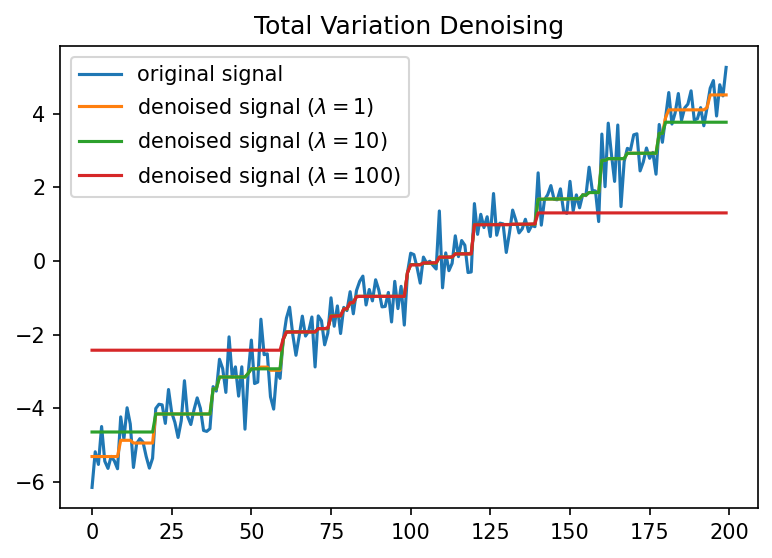

In [3]:
def tvsolver(x, lmd, maxiters=100):
    """
    Pytorch solver for the 1D total variation denoising problem. Operates on a batch of inputs
    x of size (b, n) all with same lambda.
    """

    # initialize u to x
    b, n = x.shape
    u = x.clone()
    
    # iterate
    Dx = (x[:, :-1] - x[:, 1:]).view(b, n - 1, 1)
    ones = torch.ones((b, n - 2), dtype=x.dtype, device=x.device)
    for _ in range(maxiters):
        L = torch.abs(u[:, :-1] - u[:, 1:]) / lmd
        H = torch.diag_embed(L + 2.0) - torch.diag_embed(ones, offset=1) - torch.diag_embed(ones, offset=-1)
        w = torch.cholesky_solve(Dx, torch.linalg.cholesky(H)).view(b, n - 1)
        
        u = x.clone()
        u[:, 1:] += w
        u[:, :-1] -= w
        
    return u


# generate signal
torch.manual_seed(0)
n = 200
x = torch.floor(torch.linspace(-5, 5, n)) + 0.5 * torch.randn(n, dtype=torch.double)

# find denoised signal
u_1 = tvsolver(x.view(1, n), 1.0, 1000)
u_10 = tvsolver(x.view(1, n), 10.0, 1000)
u_100 = tvsolver(x.view(1, n), 100.0, 1000)

# plot results
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(x.detach().flatten(), label="original signal")
plt.plot(u_1.detach().flatten(), label="denoised signal ($\lambda = 1$)")
plt.plot(u_10.detach().flatten(), label="denoised signal ($\lambda = 10$)")
plt.plot(u_100.detach().flatten(), label="denoised signal ($\lambda = 100$)")
plt.legend()
plt.title("Total Variation Denoising")
plt.show()

## Automatic Differentiation in Declarative Node

We can define a `TotalVariationFcn` class for differente the solution to the total variation optimization problem as a declarative node. A somewhat surprising result, albeit obvious in hindsight, is that for total variation the derivative of the denoised signal with respect to the input signal is the identity matrix. This is because the total variation objective is comprised of a quadratic term between $x$ and $u$ and linear terms in $u$. Mathematically,
$$
\frac{\mathrm{d}y}{\mathrm{d}x} = I.
$$

As such the backward pass can be implemented as a *pass through* operation.


In [4]:
class TotalVariationFcn(torch.autograd.Function):
    """PyTorch autograd function for total variation denoising."""

    @staticmethod
    def forward(ctx, x, lmd):
        with torch.no_grad():
            u = tvsolver(x.detach().clone(), lmd)
        return u

    @staticmethod
    def backward(ctx, dLdY):
        return dLdY, None

Check the gradient of the `TotalVariationFcn` class by using `gradcheck` function in PyTorch:

In [5]:
n = 5
fcn = TotalVariationFcn.apply

torch.manual_seed(4399)
X = torch.randn((1, n), dtype=torch.double, device=cpu_device, requires_grad=True)

test = gradcheck(fcn, (X, 0.2), eps=1e-6, atol=1e-3, rtol=1e-6)
print("Backward test of TotalVariationFcn: {}".format(test))

Backward test of TotalVariationFcn: True


## Bi-Level Optimization Example

To test the code, we set up the following bi-level optimisation problem where the lower level problem is the total variation denoising problem and the upper level problem aims to match the denoised signal with some target.

$$
\begin{array}{ll}
    \text{minimize}     & \frac{1}{2} \|y^\star-y^{\text{target}}\|_2^2 \\
    \text{subject to}   & y^\star = \text{argmin}_u \frac{1}{2} \|u-x \|_2^2 + \lambda \sum_{i=1}^{n-1}|u_{i+1} - u_i|
\end{array}
$$

In words, find the input signal $x$ such that after denoising, the denoised signal $y$ is close to a given target $y^\text{target}$.

In [6]:
torch.manual_seed(22)

n = 100
y_target = torch.remainder(torch.floor(torch.linspace(0, 10, n, device=global_device, dtype=torch.float)), 3.0).view(1, -1)
y_target.requires_grad = False

x_init = torch.randn((1, n), dtype=torch.float, device=global_device, requires_grad=False)
y_init = TotalVariationFcn.apply(x_init, 1.0)

x = torch.nn.Parameter(x_init.clone(), requires_grad=True)
opt = torch.optim.AdamW([x], lr=1.0e-1)

# do optimisation
x_history = []
y_history = []
loss_fcn = torch.nn.MSELoss()
for _ in range(100):
    opt.zero_grad(set_to_none=True)
    y = TotalVariationFcn.apply(x, 1.0)
    loss = loss_fcn(y, y_target)
    loss.backward()
    opt.step()
    x_history.append(x.detach().clone())
    y_history.append(y.detach().clone())

In [7]:
%%capture

def init():
    ax.plot(x_init.flatten(), label="initial x")
    ax.plot(y_init.flatten(), label="initial y")
    ax.plot(y_target.flatten(), '--', label="target y")
    ax.set_ylim(-2.0, 3.0)
    ax.legend(loc='lower right')
    return [ax]

def animate(fnum, x, y):
    ax.clear()
    ax.plot(x[fnum].flatten(), label="x at {}".format(fnum + 1))
    ax.plot(y[fnum].flatten(), label="y at {}".format(fnum + 1))
    ax.plot(y_target.flatten(), '--', label="target y")
    ax.set_ylim(-2.0, 3.0)
    ax.legend(loc='lower right')
    return [ax]

# create animation
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = plt.subplot(1, 1, 1)
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, init_func=init, fargs=(x_history, y_history),
                              interval=100, frames=len(x_history), repeat=False)
plt.close(fig)

In [8]:
from IPython.display import HTML

# display using video or javascript
HTML(ani.to_html5_video())
#HTML(ani.to_jshtml())

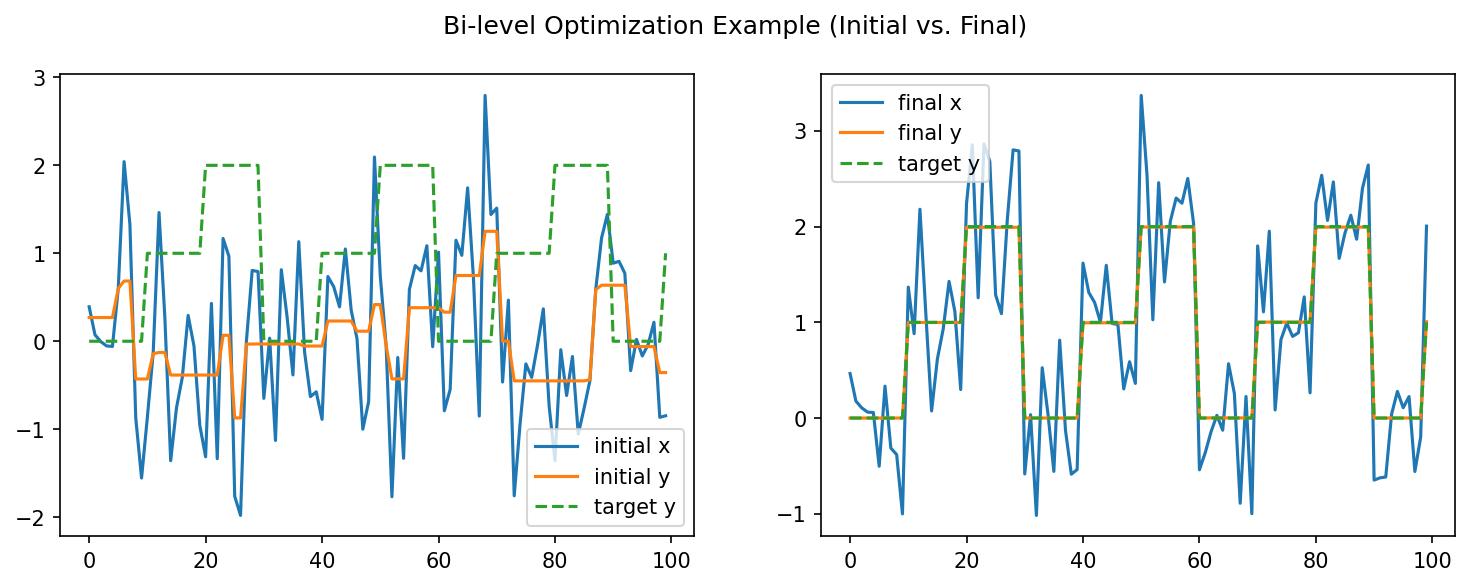

In [9]:
# plot results
plt.figure(figsize=(12, 4), dpi=150)
plt.suptitle("Bi-level Optimization Example (Initial vs. Final)")
plt.subplot(1,2,1)
plt.plot(x_init.detach().flatten(), label="initial x")
plt.plot(y_init.detach().flatten(), label="initial y")
plt.plot(y_target.detach().flatten(), '--', label="target y")
plt.legend()
plt.subplot(1,2,2)
plt.plot(x.detach().flatten(), label="final x")
plt.plot(y.detach().flatten(), label="final y")
plt.plot(y_target.detach().flatten(), '--', label="target y")
plt.legend()
plt.show()

Notice that the bi-level optimization problem does not remove noise from the input signal $x$. Removing noise is the responsibility of the total variation denoising in the lower level. What the bi-level problem does do is modify the input signal so that its denoised version $y$ matches the target.

For this (toy) problem we could have removed the lower level problem and optimized $x$ directly to match $y^\text{target}$ since we're able to update each component of $x$ independently. However, the ability to back propagate through total variation denoising allows us to update other (more restricted) data generating models. The distinction between updating $x$ to match $y^\text{target}$ versus updating $x$ so that $y$ matches $y^\text{target}$ may then become important.

## Acknowledgements

This tutorial was adapted from a coursework project done by ANU student Yiran Mao.